In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import time
# %matplotlib qt
# %matplotlib inline
import pickle
calibration_flag = 0

In [2]:
def showImg(img):
    plt.imshow(img)
    plt.show()

## Find Chessboard Corners

In [3]:
if calibration_flag == 1:
    # Set numb er of chessboard points
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in tqdm(enumerate(images)):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    #         cv2.imshow('img', img)
    #         cv2.waitKey(500)

    cv2.destroyAllWindows()

## Create mtx and dist matrices to Calibrate Camera

In [4]:
if calibration_flag == 1:
    # Test undistortion on an image
    img = cv2.imread('test_images/test1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test1_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    # pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

## Colour Thresholding

In [5]:
# def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def pipeline(img, s_thresh=(100, 255), sx_thresh=(20, 150)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined

## Tranform Image to Top View

In [6]:
def plotResult(original, new):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        cmap1=None
    else:
        cmap1='gray'
        
    ax1.imshow(original, cmap=cmap1)
    ax1.set_title('Original Image', fontsize=40)
    
    if len(original.shape) == 3:
        new = cv2.cvtColor(new, cv2.COLOR_BGR2RGB)
        cmap2=None
    else:
        cmap2='gray'
        
    ax2.imshow(new, cmap=cmap2)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
# Load Pickled mtx, dist and M for image calibration and transformation
pickle_file = open( "camera_cal/dist_pickle.p", "rb" )
dist_pickle = pickle.load( pickle_file )
dist = dist_pickle['dist']
mtx = dist_pickle['mtx']

# Set number of chessboard points
nx = 9
ny = 6

def reproject(image, nx, ny, mtx, dist ):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if image.shape == 3:
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1], gray.shape[0])
    else:
        img_size = (image.shape[1], image.shape[0])
        
    if image.shape[0] == 720:
        # Working for full sized image
        src = np.float32([[281, 673] ,[560, 477 ] ,[720, 477 ] ,[1040, 673] ])
        dst = np.float32([[281, 673] ,[281, 477] ,[1040, 477] ,[1040, 673]])

    else:
        # Cropped image
        src = np.float32([[280, 285] ,[559, 77 ] ,[729, 77 ] ,[1049, 285]  ])
        dst = np.float32([[280, 285] ,[280, 77] ,[1049, 77] ,[1049, 285] ])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped


# new = reproject(image, nx, ny, mtx, dist )   
# plotResult(image, new)

## Lane finding with convolutions

In [149]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def findLanes(warped):
    # window settings
    window_width = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    pts_l = []
    pts_r = []
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Make some empty lists to store window centroids

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            # Add left and right points to a list for later use
            pts_l.append( window_centroids[level][0] )
            pts_r.append( window_centroids[level][1] )
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        # Convert lists into array
        pts_l = np.asarray(pts_l)
        pts_r = np.asarray(pts_r)
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
       

    return output, l_points, r_points

## Measure Curvature

In [ ]:
# def measureCurve(leftx, rightx):  
 
#     ploty = np.linspace(0, 720, num=9) # to cover same y-range as image    
#     ploty = ploty[::-1]  # flip y
#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#     Fit a second order polynomial to pixel positions in each fake lane line
#     left_fit = np.polyfit(ploty, leftx, 2)    
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fit = np.polyfit(ploty, rightx, 2)
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Plot up the fake data
#     mark_size = 3
#     plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#     plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#     plt.xlim(0, 1280)
#     plt.ylim(0, 720)
#     plt.plot(left_fitx, ploty, color='green', linewidth=3)
#     plt.plot(right_fitx, ploty, color='green', linewidth=3)
#     plt.gca().invert_yaxis() # to visualize as we do the images


#     ## Convert curvature to metres
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
#     y_eval = np.max(ploty)
    
#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
#     print('Curve Radii => Left', left_curverad, 'm, Right', right_curverad, 'm')
#     # Example values: 632.1 m    626.2 m

In [158]:
# def measureCurve(leftx, rightx):  
def measureCurve(lx, ly, rx, ry):    
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ly, lx, 2)    
    left_fitx = left_fit[0]*ly**2 + left_fit[1]*ly + left_fit[2]
    right_fit = np.polyfit(ry, rx, 2)
    right_fitx = right_fit[0]*ry**2 + right_fit[1]*ry + right_fit[2]

    ## Convert curvature to metres
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
    y_eval = np.max(720)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Curve Radii => Left', left_curverad, 'm, Right', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, [left_fitx, right_fitx]

In [10]:
# Get points
%matplotlib qt
image = cv2.imread('test_images/straight_lines1.jpg')
showImg(image)

In [151]:
def img2XY(img):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

## FLOW CONTROL

Curve Radii => Left 508.101306495 m, Right 76.8325828387 m
Curve Radii => Left 175.332917271 m, Right 171.221939304 m
Curve Radii => Left 204.581426216 m, Right 75.0848337127 m
Curve Radii => Left 730.010826419 m, Right 77.3406533583 m
Curve Radii => Left 246.229037202 m, Right 85.6004389201 m
Curve Radii => Left 382.73948151 m, Right 89.5661473744 m


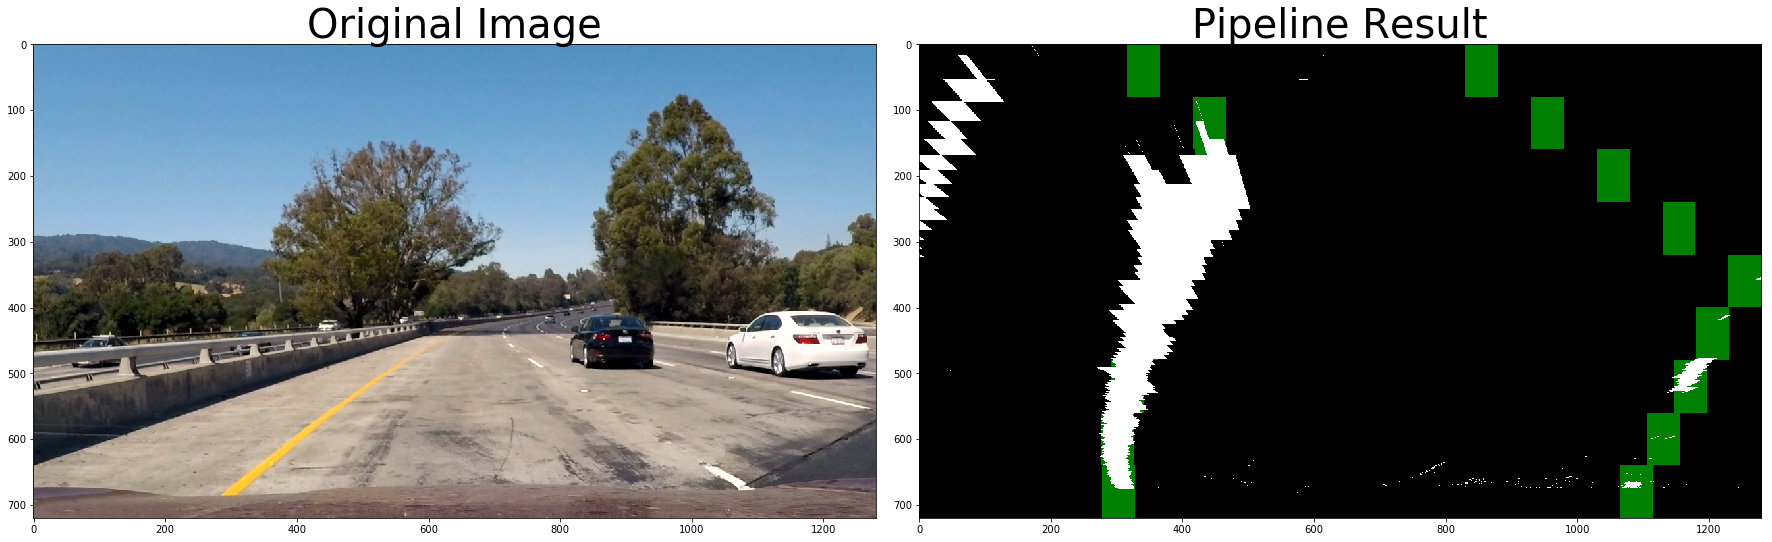

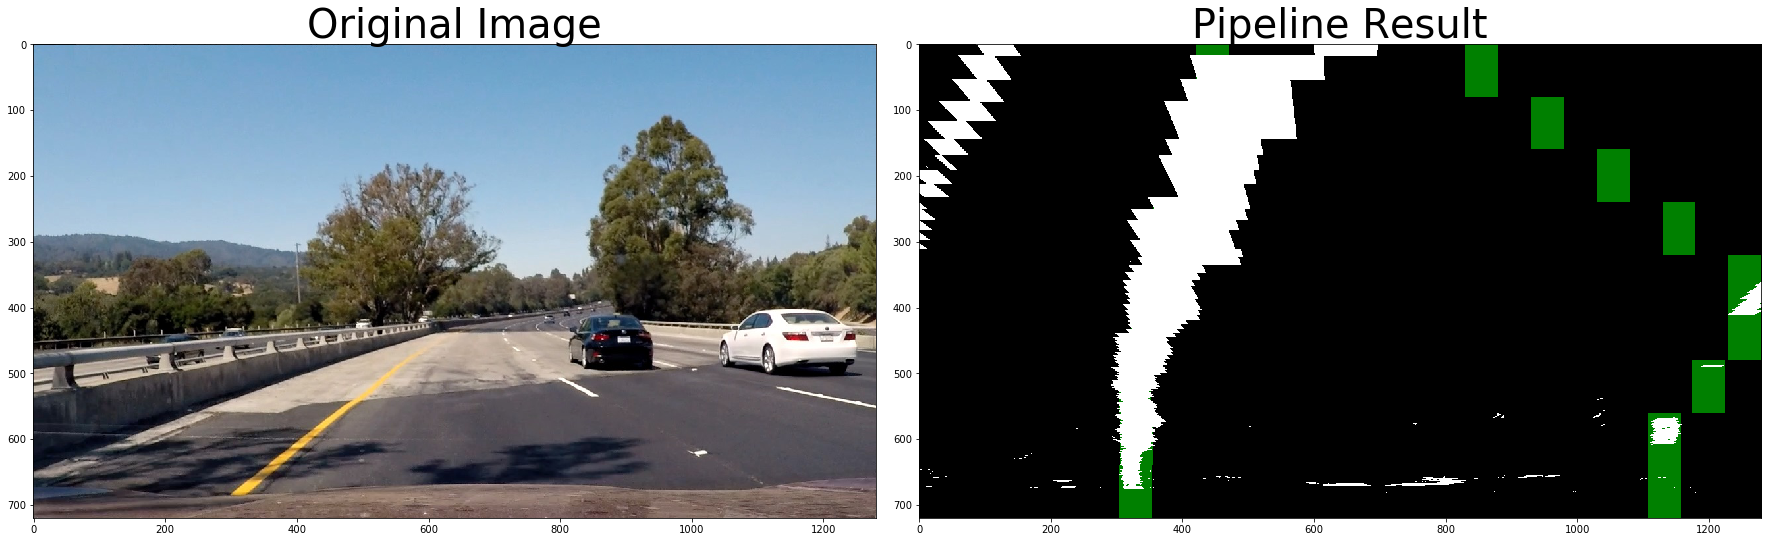

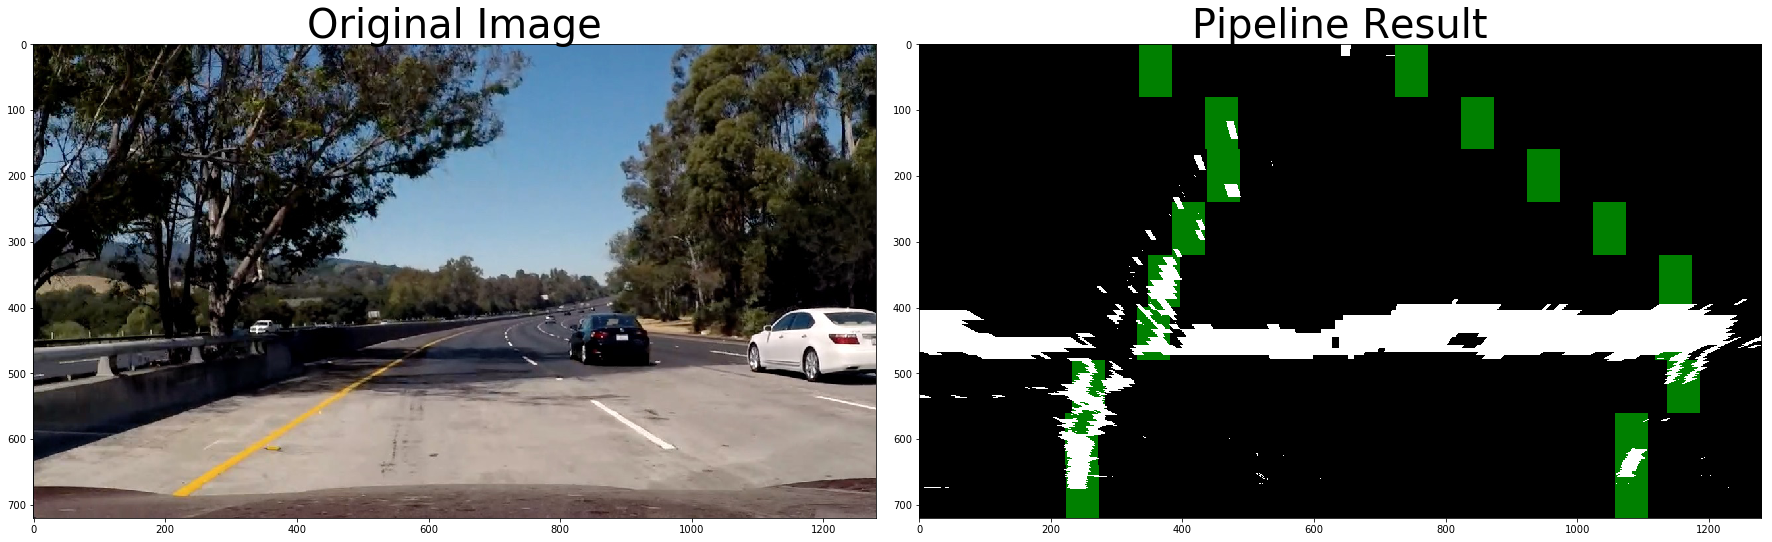

In [172]:
%matplotlib inline
images = glob.glob('test_images/test*.jpg')
# Step through the list of images
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    # undistort and transform
    result, combined = pipeline(image) #result, combined = pipeline(image[400:700, :])
    
    # Convert Binary Black and White IMage to float
    img = combined.astype(np.float32)
    new = reproject(img, nx, ny, mtx, dist )   
    
    # Convert 1's to 255
    img_bw = np.zeros_like(new)
    img_bw[new == 1] = 255
    img_bw = np.array(img_bw, dtype = np.uint8) # img_bw = img_bw.astype(np.int32) # to int32
    
    # Find Lane Lines (takes a grayscale image 0-255)
    lanes, pts_l, pts_r = findLanes(img_bw) 
    
    # Turn Image into X and Y Coords
    lx, ly = img2XY(pts_l)
    rx, ry = img2XY(pts_r)
    
    left_curverad, right_curverad, fits = measureCurve(lx, ly, rx, ry)
    left_fitx = fits[0]
    right_fitx = fits[1]
    
    # PLOT FUNCTION 1
    # make a function that plots the black and white background image
    # with the 2 curve fits overlaid
    
    
    plotResult(image, lanes)
    
    # Save to file
    write_name = 'out/lanes_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, lanes )


## Function Plots the green carpet on the lane of the original Image

In [ ]:
def carpetPlotter(warped, ploty, left_fitx,  right_fitx, )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)